### Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Futurists vs. Scientists

### Notebook 1 of 3: Preprocessing, EDA 

### Problem statement

Enthralled as I am with the future, high-flying visions of art merging with technology that bring about utopia seem  ungrounded and unscientific.

Using classification models on datasets collected from the [`futurology`](https://www.reddit.com/r/Futurology) and [`science`](https://www.reddit.com/r/Science) subreddits, I'd like to answer some of the below questions (where possible):

* Are the futurist and scientist communities mutually exclusive? 

* What is the nature of the discussions amongst the scientist community?

* What is the nature of the discussions amongst the futurist community?

* Where is there topical crossover between these discussions, if any? 

* Does the topical crossover support any of the visions of the future held and propagated by futurists, such as:
  
     * Mind uploading, digital heaven, etc.
     * Reverse-aging, insect-based diets, colonization of other planets, etc.

* Furthermore, are solutions being discussed to the disaster-visions of futurists, such as:
    * Food and water shortages
    * Environmental disasters



#### Libary imports

In [672]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import CountVectorizer
import string


import warnings; warnings.simplefilter('ignore')
##this will hide deprecation/future warnings

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

#### Data collection

I utilized the Python Reddit API Wrapper (PRAW) API in the data collection process. You can find the steps I took in the `PRAW_data_collection` notebook, located in the code folder of this repository.

The East Coast local instructors were very generous with their walkthrough of the process, so I definitely credit them for the ease of the data collection.

From the [rubric](https://git.generalassemb.ly/abishop17/project_3/blob/master/README.md):

>Was data collection and storage optimized through custom functions, pipelines, and/or automation? <br><br>
>Was thought given to the server receiving the requests such as considering number of requests per second?

#### Preprocessing and EDA

#### Dataset 1: "New" flavor, pulled from Reddit on 10/13/20

In [673]:
subred1 = pd.read_csv('../data/df_with_both_subs.csv', index_col = 'id')
subred1 = subred1.drop(columns = 'Unnamed: 0')
display(pd.set_option('display.max_colwidth', 50), subred1.head())

None

,title,score,url,comms_num,created,body,subreddit
id,,,,,,,
japxs3,What would the point be to do anything if AI c...,0,https://www.reddit.com/r/Futurology/comments/j...,4,1.602664e+09,The more I look into AI and new projects like ...,futurology
japq75,ELCC Explained: the Critical Renewable Energy ...,4,https://blog.ucsusa.org/mark-specht/elcc-expla...,0,1.602663e+09,NaN,futurology
jaojnb,There's a 50-50 chance we're living in a simul...,8,https://boingboing.net/2020/10/13/new-research...,4,1.602659e+09,NaN,futurology
jaofpy,"Eight nations sign NASA's Artemis Accords, ple...",3,https://www.engadget.com/nasa-artemis-accords-...,1,1.602658e+09,NaN,futurology
jaocqq,Mercedes benz AVTR - In Action,8,https://www.youtube.com/watch?v=ChqM3zqTREQ&ab...,0,1.602658e+09,NaN,futurology


---

### EDA

In [674]:
display(subred1[['title', 'subreddit']].head(1))
display(subred1[['title', 'subreddit']].tail(1))

,title,subreddit
id,,
japxs3,What would the point be to do anything if AI c...,futurology


,title,subreddit
id,,
iqysvn,Study finds middle-aged individuals — those bo...,science


#### Address duplicates

In [675]:
printmd('**Count of unique titles:**')
display(subred1['title'].nunique())
printmd('**Count of titles before dropping duplicates:**')
display(subred1['title'].count())

subred1 = subred1.drop_duplicates()

printmd('**Count of titles after dropping duplicates:**')
subred1['title'].nunique()

**Count of unique titles:**

1778

**Count of titles before dropping duplicates:**

1800

**Count of titles after dropping duplicates:**

1778

In [676]:
printmd('**Value counts:**')
display(subred1['subreddit'].value_counts())

printmd('**Value counts by weight:**')
subred1['subreddit'].value_counts(normalize = True)

**Value counts:**

science       931
futurology    869
Name: subreddit, dtype: int64

**Value counts by weight:**

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

* I may want to return to the subreddits to get a bigger dataset to work with. 

* The classes are slightly unbalanced, so that will be a consideration during the preprocessing / get-more-data phase.

In [677]:
# Null body rows
printmd(f"**Only {len(subred1['body'][(subred1['body'].isnull()).astype(int) == 0])} non-null `body` records.**")

non_null_body = subred1[['body', 'subreddit']][(subred1['body'].isnull()).astype(int) == 0]

**Only 69 non-null `body` records.**

**Ignore `body` column since there are so few in the dataset.**

In [678]:
printmd('**Can we get enough content from post titles?**')

**Can we get enough content from post titles?**

---

In [679]:
display(pd.set_option('display.max_colwidth', 300), subred1[['title', 'body']])

None

,title,body
id,,
japxs3,What would the point be to do anything if AI could just do it all for us?,"The more I look into AI and new projects like GPT-3, we humans suck. Sure GPT-3 isn't on the level as a human brain, but that doesn't mean gpt-4 or gpt-5 won't be. I can already see the massive jobs loss as AI will offset more jobs than it will create. I'm just feeling a little existential cris..."
japq75,"ELCC Explained: the Critical Renewable Energy Concept You’ve Never Heard Of ""Now we live in a day and age where some parts of the country generate more than 30% of their electricity with variable renewables, and that number will fast approach 100% in the decades to come.""",NaN
jaojnb,"There's a 50-50 chance we're living in a simulation and here's how to find out ""the probability will increase as we develop technology enabling the creation of a simulation containing conscious beings.""",NaN
jaofpy,"Eight nations sign NASA's Artemis Accords, pledging peace on the moon ""It's a reaffirmation of the 1967 Outer Space Treaty.""",NaN
jaocqq,Mercedes benz AVTR - In Action,NaN
...,...,...
ir136p,Adults with positive SARS-CoV-2 test results were approximately twice as likely to have reported dining at a restaurant than were those with negative SARS-CoV-2 test results.,NaN
ir0vem,50% of Phosphorus Lost to Erosion,NaN
ir0pvm,Motivated Helplessness in the Context of the Covid-19 Pandemic: Evidence for a Curvilinear Relationship Between Perceived Ability to Avoid the Virus and Anxiety,NaN


**Lemmatizing**, ***aka Soft wash***

In [680]:
lemmatizer = WordNetLemmatizer()

def split_and_lemmatize(string):
    word = ''
    for i in string.split():
        word += lemmatizer.lemmatize(i + ' ')
    return word

# Lemmatize titles

display(subred1['title'].apply(split_and_lemmatize).head(1))

id
japxs3    What would the point be to do anything if AI could just do it all for us? 
Name: title, dtype: object

**Stemming**, ***aka Aggressive wash***

In [681]:
# stemmer = PorterStemmer()  #instantiate stemmer

# def split_and_stem(string):
#     word = ""   #empty string
#     string = string.split(' ') #creates list of words
#     for i in string: #iterates through that list of words
#         word += (stemmer.stem(i) + " ")  #stems each word and adds to empty string
#     return word  #returns string with stemmed words

# # ref: Heather Robinson at General Assembly :-)

# Apply stemming to title 

# subred1['title'] = subred1['title'].apply(split_and_stem)

# subred1['title'].head()

#### Binarize the target feature: `1` for Science, `0` for Futurology

In [682]:
# Check the balance of classes

printmd('**Balance of classes before binarizing**')
display(subred1['subreddit'].value_counts())
display(subred1['subreddit'].value_counts(normalize = True))

subred1['subreddit'] = subred1['subreddit'].map({'science': 1, 'futurology': 0})

printmd('**Balance of classes after binarizing (Science: 1, Futurology: 0)**')
display(subred1['subreddit'].value_counts())

**Balance of classes before binarizing**

science       931
futurology    869
Name: subreddit, dtype: int64

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

**Balance of classes after binarizing (Science: 1, Futurology: 0)**

1    931
0    869
Name: subreddit, dtype: int64

In [607]:
subred1.to_csv('../data/cleaned_data/cleaned_df_1.csv')

### Cutoff point 

#### To toggle between Option 1 (EDA)  and Option 2 (Optimal modeling) below:
**Step 1**: Click on this cell, then select the following from the Jupyter Notebook menu:  `Cell`  > `Run all above`

**Step 2**: Run the cells within each section below

**Step 3**: After running the last cell within the section, repeat `Step 1`, and go to the next section 

---

#### Set the features

In [608]:
# Set feature matrix and target variable

X = subred1['title']
y = subred1['subreddit']

### Implement CountVectorizer for purposes of EDA

### Preprocessing
- Remove special characters
- Tokenize
- Lemmatize / stem
- Remove stop words

#### CountVectorizer

1. Count number of times a token is observed in a given subreddit post

2. Create a vector to store those counts

In [609]:
# Instantiate CountVectorizer 
cvec = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on the corpus
X = cvec.fit_transform(X)

printmd('**Size of feature matrix:**')
display(X.shape)

printmd(f'**Count of tokens:** {len(cvec.get_feature_names())}')

printmd('**Have a look at random slices of our tokens:**')
for i in np.arange(0, len(cvec.get_feature_names()), step = 1_000):
    increment = 20
    print('\n', cvec.get_feature_names()[i: i + increment])

**Size of feature matrix:**

(1800, 6364)

**Count of tokens:** 6364

**Have a look at random slices of our tokens:**


 ['000', '01', '012', '026', '061', '083', '10', '100', '1000', '1000x', '100m', '1010g', '1062', '107', '10g', '10gw', '10th', '11', '113', '114']

 ['capac', 'capacity', 'cape', 'capit', 'capita', 'capitalism', 'capitalist', 'capsid', 'capsul', 'capsule', 'captur', 'capture', 'car', 'carbohydr', 'carbon', 'carboxyl', 'carboxymethyl', 'carcinoma', 'cardiac', 'cardiolog']

 ['encrypt', 'encycl', 'end', 'endang', 'endless', 'endocanabinoids', 'endocannabinoids', 'endogen', 'endors', 'energi', 'energy', 'enforc', 'enforced', 'engag', 'engagement', 'engin', 'engine', 'engineering', 'england', 'english']

 ['infrastructur', 'infus', 'ingest', 'ingredi', 'inhal', 'inher', 'inherit', 'inhibit', 'inhibitor', 'initi', 'initiation', 'inject', 'injuri', 'injuries', 'injury', 'ink', 'inner', 'innov', 'innovation', 'innovations']

 ['ny', 'nyc', 'nylon', 'oae2', 'obamacare', 'obes', 'obese', 'obesity', 'object', 'obligations', 'observ', 'observatori', 'obstruct', 'obtain', 'occasion', 'occup', 'o

In [620]:
features_and_subreddit = pd.concat([pd.Series(cvec.get_feature_names()), y], axis = 1)
features_and_subreddit.head(100)

,0,subreddit
0,000,NaN
1,01,NaN
2,012,NaN
3,026,NaN
4,061,NaN
5,083,NaN
6,10,NaN
7,100,NaN
8,1000,NaN
9,1000x,NaN


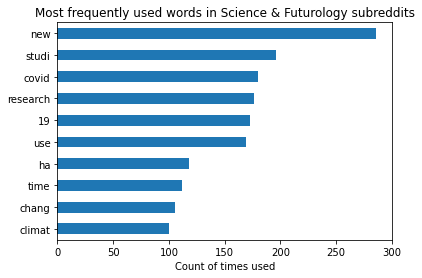

In [347]:
# Convert training data to dataframe
X = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# Plot top occurring words
X.sum().sort_values(ascending = False).head(10)[::-1].plot(kind = 'barh')

plt.title('Most frequently used words in Science & Futurology subreddits')
plt.xlabel('Count of times used');

<br>